In [1]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import numpy as np
import math

In [22]:
df = pd.read_csv('trade_1988_2021.csv')
df.dropna(inplace=True)
df.head()

,ReporterISO3,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeValue in 1000 USD
0,AFG,Afghanistan,SWE,Sweden,2017,Export,86.752
1,AFG,Afghanistan,JOR,Jordan,2018,Export,2796.481
2,AFG,Afghanistan,JOR,Jordan,2017,Export,3100.187
3,AFG,Afghanistan,ITA,Italy,2018,Export,279.918
4,AFG,Afghanistan,ITA,Italy,2017,Export,416.642


In [2]:
def momment(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [6]:
for year in df['Year'].unique():
    dfyear = df[df['Year'] == year]
    dfyear[['ReporterISO3', 'PartnerISO3', 'TradeValue in 1000 USD']].to_csv(f'RedesAnos/{year}.txt', sep=' ', index=False, header=False)

In [78]:
G= nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))

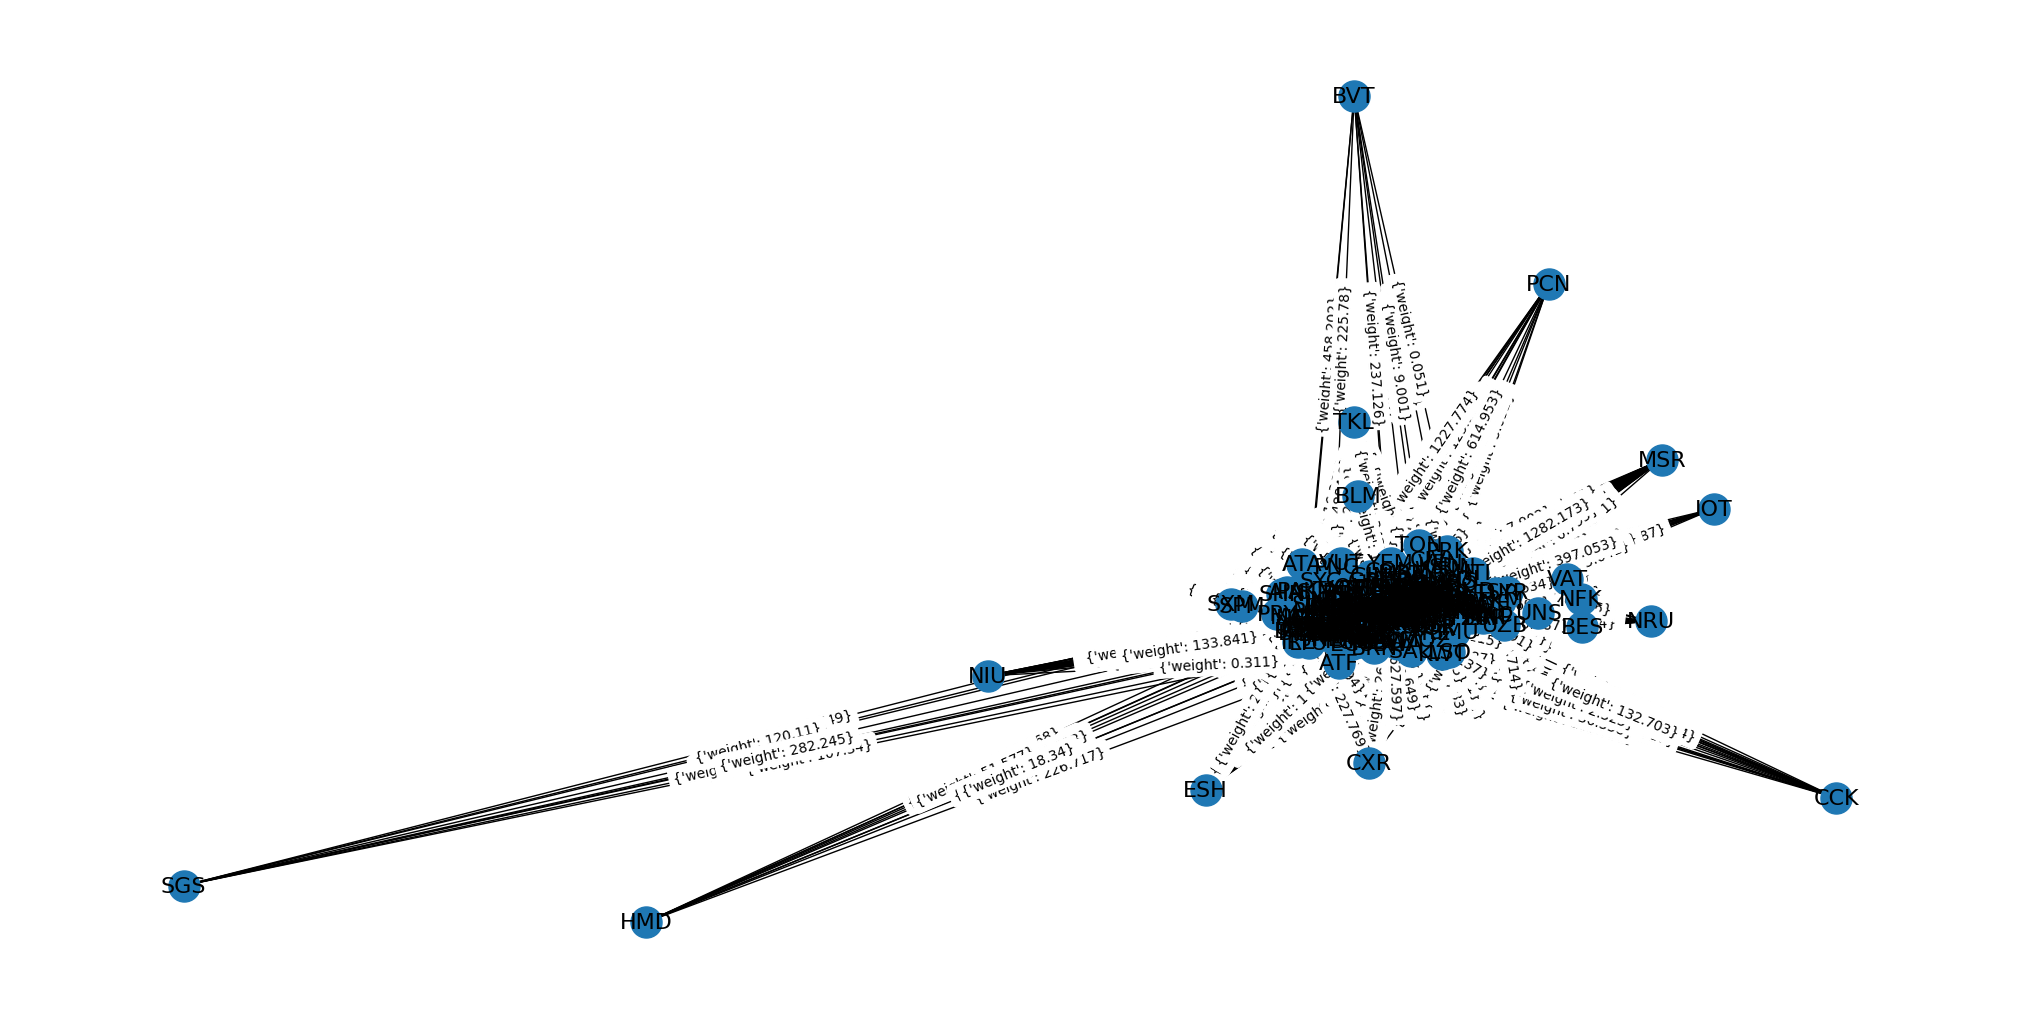

In [8]:
import matplotlib.pyplot as plt


pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

In [92]:
weights = []
for year in np.sort(df['Year'].unique()):
    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
    for (u,v,w) in G.edges(data=True):
        weights.append(w['weight'])


min_weight = np.median(weights)
print(np.median(weights))
print(min_weight)

# min_weight = 30000
G = nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))
Gnew = nx.Graph()
for (u,v,w) in G.edges(data=True):
    if w['weight'] > min_weight :
        Gnew.add_edge(u, v, weight=1)
G = Gnew

1871.0565
1871.0565


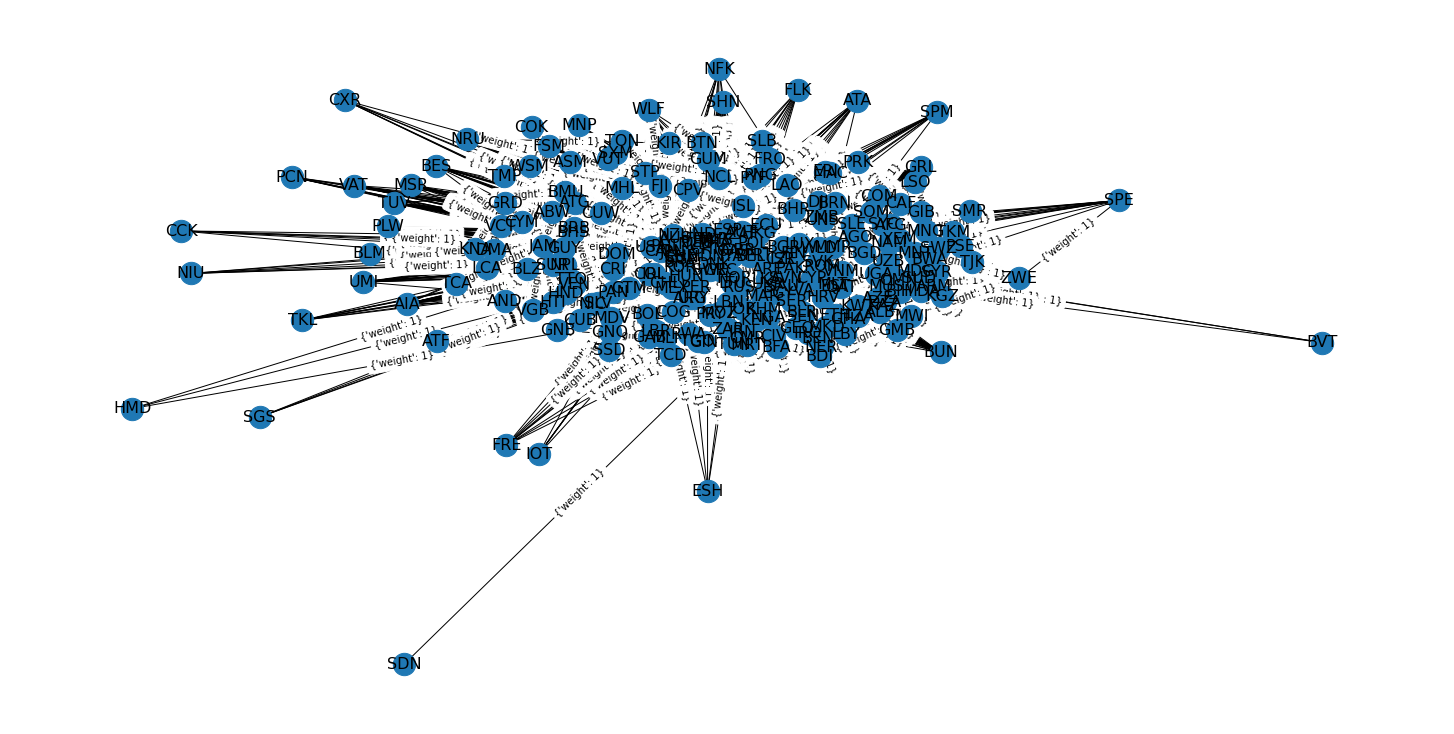

In [81]:
import matplotlib.pyplot as plt


pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

Gerar redes para diversos anos e calcular medidas: average shortest path length,
entropia do grau, média do eigenvector centrality, modularidade etc.

In [17]:
G2020 = nx.read_edgelist(f'RedesAnos/2020.txt',data=(("weight", float),))
G2021 = nx.read_edgelist(f'RedesAnos/2021.txt',data=(("weight", float),))
# Transformando as arestas em uma lista de tuplas dos vertices
a2020 = list(map(tuple, np.array(list(G2020.edges(data=True)))[:, :2]))
a2021 = list(map(tuple, np.array(list(G2021.edges(data=True)))[:, :2]))
l = list(set(a2021) & set(a2020))

In [132]:
G = nx.read_edgelist(f'RedesAnos/1989.txt',data=(("weight", float),))
previousYear = G

currentYear = nx.read_edgelist(f'RedesAnos/1990.txt',data=(("weight", float),))
currentYearEdges = list(map(tuple, np.array(list(currentYear.edges(data=True)))[:, :2]))

# Colhetando info do ano anterior com os vertices recuperados
previousYearEdges = list(map(tuple, np.array(list(previousYear.edges(data=True)))[:, :2]))     
# Definindo os vertices semelhantes entre os anos   
simEdges = list(set(previousYearEdges) & set(currentYearEdges))

In [140]:
0 if len(previousYear.get_edge_data('BLX', 'UGA')) == 0 else previousYear.get_edge_data('BLX', 'UGA')['weight']

0

In [138]:
len(previousYear.get_edge_data('BLX', 'UGA'))

0

In [129]:
simEdges

[('VNM', 'AGO'),
 ('VNM', 'SEN'),
 ('THA', 'EUN'),
 ('BGR', 'ATF'),
 ('IND', 'JAM'),
 ('USA', 'MLT'),
 ('ROM', 'MLT'),
 ('ITA', 'ISR'),
 ('DEU', 'SER'),
 ('CMR', 'PAN'),
 ('DNK', 'SMR'),
 ('KOR', 'ATA'),
 ('OAS', 'BEN'),
 ('GIN', 'SUD'),
 ('AZE', 'ISL'),
 ('VNM', 'QAT'),
 ('IND', 'AIA'),
 ('HRV', 'YEM'),
 ('KAZ', 'POL'),
 ('BHR', 'VEN'),
 ('MKD', 'CYP'),
 ('LKA', 'BLZ'),
 ('ZAF', 'NER'),
 ('THA', 'GUM'),
 ('UKR', 'BLZ'),
 ('PER', 'NPL'),
 ('HRV', 'BUN'),
 ('ARE', 'EST'),
 ('CHL', 'SLV'),
 ('IRN', 'IRQ'),
 ('LKA', 'NGA'),
 ('SVK', 'MDV'),
 ('NZL', 'MWI'),
 ('BGD', 'USA'),
 ('VNM', 'SLE'),
 ('ARM', 'DOM'),
 ('IRL', 'QAT'),
 ('KAZ', 'AND'),
 ('ITA', 'HND'),
 ('LAO', 'EUN'),
 ('MDA', 'SYR'),
 ('AFG', 'FRA'),
 ('BRA', 'GRL'),
 ('BEL', 'EGY'),
 ('DEU', 'TKM'),
 ('JAM', 'TTO'),
 ('MYS', 'CYP'),
 ('SVN', 'VGB'),
 ('CHN', 'USA'),
 ('CHN', 'BES'),
 ('JPN', 'MHL'),
 ('KOR', 'CIV'),
 ('GMB', 'MRT'),
 ('AUT', 'MDV'),
 ('NLD', 'CAN'),
 ('EST', 'GRL'),
 ('BLR', 'TUN'),
 ('CHN', 'MSR'),
 ('RUS', 'MWI'

In [149]:
result = pd.DataFrame(columns = ['Grau Medio', 'Entropia', 'Menor caminho medio', 'Eigenvector centrality', 'Assortatividade', 'Modularidade', 'Closeness centrality', 'Diametro', 'Eficiencia Global'])
medidas = []
years = np.sort(df['Year'].unique())
lostnodes = []
lost_rate = 0.5
recover_rate = 0.05

for i in range(len(years)):
    if i == 0:
        G = nx.read_edgelist(f'RedesAnos/{years[i]}.txt',data=(("weight", float),))
        previousYear = G
    else:
        # Colhetando info do ano atual e suas arestas
        currentYear = nx.read_edgelist(f'RedesAnos/{years[i]}.txt',data=(("weight", float),))
        currentYearEdges = list(map(tuple, np.array(list(currentYear.edges(data=True)))[:, :2]))
        
        # Tentando recuperar vertices perdidos
        if len(lostnodes) > 0:
            arr_lostnodes = np.array(lostnodes)
            try_recover = list(set(list(map(tuple, arr_lostnodes[:, :1]))) & set(currentYearEdges))
            
            for j in try_recover:
                index = next((i for i, x in enumerate(lostnodes) if x[0] == j), None)
                peso = currentYear.get_edge_data(j[0], j[1])['weight']
                print(lostnodes[index][1] , peso)
                if lostnodes[index][1] < peso:
                    previousYear.add_edge(j[0], j[1], weight = peso)
                    lostnodes.pop(index)
        
        # Colhetando info do ano anterior com os vertices recuperados
        previousYearEdges = list(map(tuple, np.array(list(previousYear.edges(data=True)))[:, :2]))     
        # Definindo os vertices semelhantes entre os anos   
        simEdges = list(set(previousYearEdges) & set(currentYearEdges))
        
        # Definindo os vertices que se manterao e que serao perdidos
        new_lostnodes = []
        G = nx.Graph()
        # print(years[i])
        for j in simEdges:
            # print(j)
            peso_anterior = 0 if len(previousYear.get_edge_data(j[0], j[1])) == 0 else previousYear.get_edge_data(j[0], j[1])['weight']
            peso_atual = 0 if len(currentYear.get_edge_data(j[0], j[1])) == 0 else currentYear.get_edge_data(j[0], j[1])['weight']
            if peso_anterior*lost_rate < peso_atual:
                G.add_edge(j[0], j[1])
                
            elif len(lostnodes) > 0 and j in np.array(lostnodes)[:, :2]:
                new_lostnodes.append([j, previousYear.get_edge_data(j[0], j[1])['weight']*lost_rate])
        
        # Diminuindo o threshold de recuperacao 
        if len(lostnodes) > 0:
            arr_lostnodes = np.array(lostnodes)        
            arr_lostnodes[:, 1:] = arr_lostnodes[:, 1:]*(1-recover_rate)
            lostnodes = arr_lostnodes.tolist()
            lostnodes.extend(new_lostnodes)
        
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G = G.subgraph(Gcc[0])
        previousYear = G
    
        
    avg_dg = momment(G, 1)
    entropy = shannon_entropy(G)
    short_path = nx.average_shortest_path_length(G)
    eign_mean = np.mean(list(dict(nx.eigenvector_centrality(G)).values()))
    assortativity = nx.degree_assortativity_coefficient(G)
    lc = nx.community.louvain_communities(G)
    mod = nx.community.modularity(G, lc)
    
    close = np.mean(list(dict(nx.closeness_centrality(G)).values()))
    diameter = nx.diameter(G)
    ef = nx.global_efficiency(G)
    
    meds = [avg_dg, entropy, short_path, eign_mean, assortativity, mod, close, diameter, ef]
    
    result.loc[years[i]] = meds

In [147]:
result.head(3)

,Grau Medio,Entropia,Menor caminho medio,Eigenvector centrality,Assortatividade,Modularidade,Closeness centrality,Diametro,Eficiencia Global
1988,43.404878,4.900872,1.790100,0.059263,-0.756825,0.111836,0.575174,3.0,0.605906
1989,34.640394,5.136488,1.863874,0.057446,-0.741245,0.069240,0.548548,4.0,0.579879
1990,22.554455,4.882543,1.968474,0.057057,-0.718226,0.111483,0.514545,4.0,0.543064


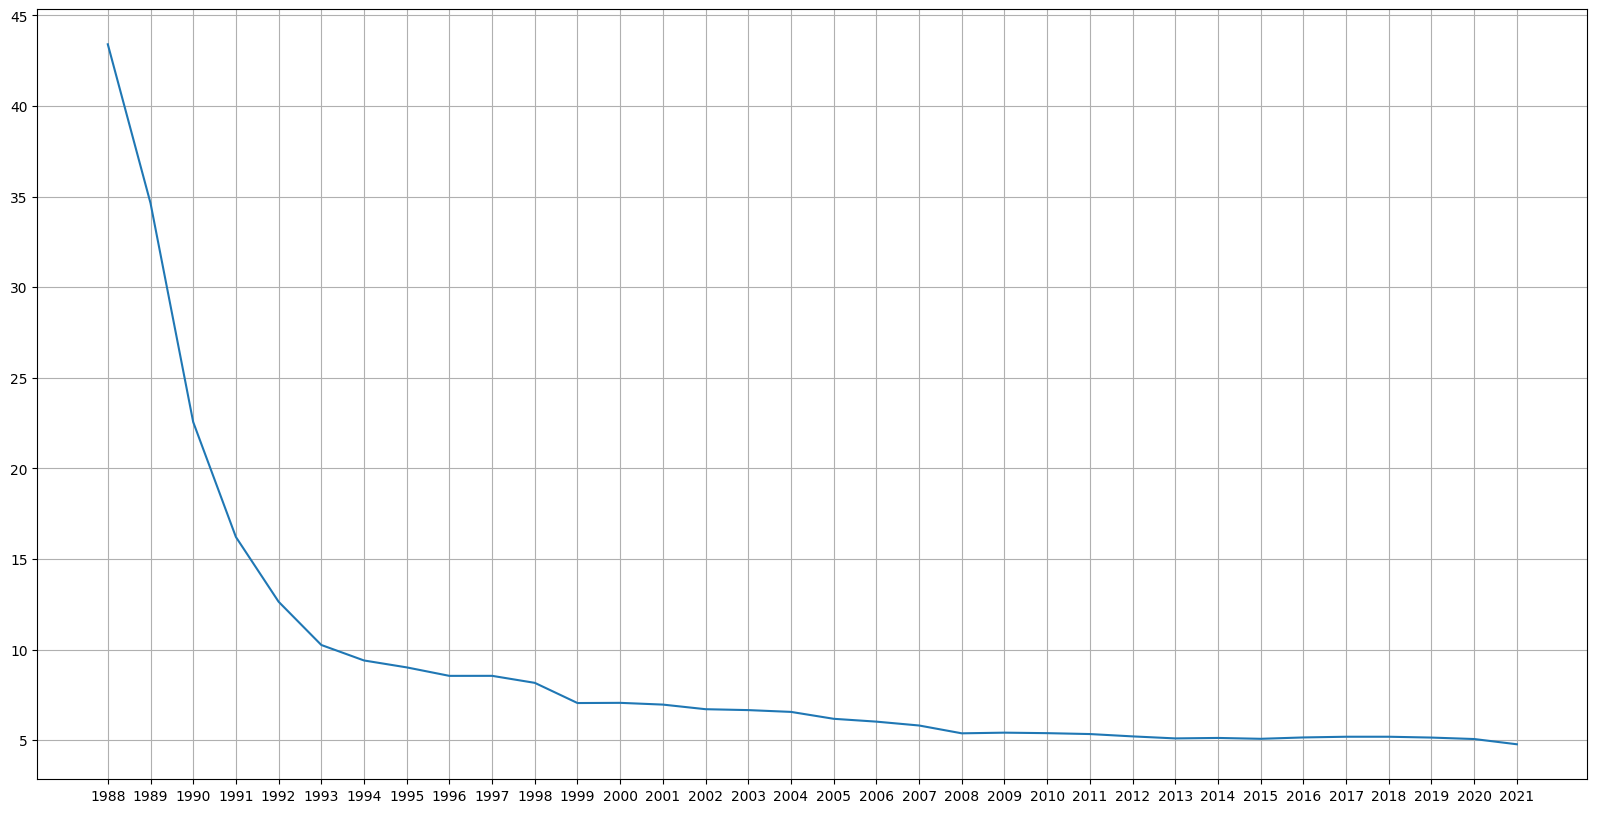

In [148]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.grid(True)
plt.plot(result['Grau Medio'])
plt.show()